# Machine Learning 2
## Regression task
### Tomasz Starakiewicz
### 28.02.2023

In [194]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_validate, LearningCurveDisplay, ShuffleSplit
from sklearn import metrics

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

### Data

The dataset contains used cars listings scraped from the internet (specific website is unknown, but we know these are UK listing), which have been published in 2020 on Kaggle under the link below:
https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

### Problem
The goal is to build an predictive model for the Audi brand. This can then be used in two ways:
- to price own car one is about to sell on the secondary market, to avoid underpricing
- to identify bargains, when new offers are scraped and price with the models - when actual price diverges from the expected price, this might indiciate the owner has underpriced their car (but might also mean simply that the car has a hidden flaw we are not aware of and are not able to model)


In [195]:
df = pd.read_csv('../data/audi.csv')
print('Observations:', len(df))
print('NAs in target variable:', df['price'].isna().sum())

Observations: 10668
NAs in target variable: 0


The dataset contains 10k observations, all with a proper target variable.

### Data partitioning

We partition the data before EDA, to ensure no bias finds its way into the model building.

In [196]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

### Exploratory Data Analysis

There appear to be 5 numerical features:
- interval: year
- ratio: mileage, tax, mpg, engineSize

However, we need to verify if some of them are not better treated as ordinal variables with low cardinality, e.g. engineSize, since they are likely to have only a few distinct values.

In [197]:
display(X_train.describe())

,year,mileage,tax,mpg,engineSize
count,8534.000000,8534.000000,8534.000000,8534.000000,8534.000000
mean,2017.103000,24790.511601,125.984298,50.759655,1.927795
std,2.173977,23509.775884,67.374140,12.949907,0.602725
min,1997.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,6000.000000,125.000000,40.900000,1.500000
50%,2017.000000,19010.000000,145.000000,49.600000,2.000000
75%,2019.000000,36275.250000,145.000000,58.900000,2.000000
max,2020.000000,323000.000000,580.000000,188.300000,6.300000


There are 3 categorical features:
- low cardinality: transimission, fuelType
- high cardinality: model

With 'model' variable, we need to definitely explore whether only the top groups should be kept distinct, the rest grouped into 'other'.

In [198]:
display(X_train.describe(include='O'))

,model,transmission,fuelType
count,8534,8534,8534
unique,26,3,3
top,A3,Manual,Diesel
freq,1559,3475,4424


All of the variables represent some degree of skewness and outliers, so for some models variable transformations will be necessary.

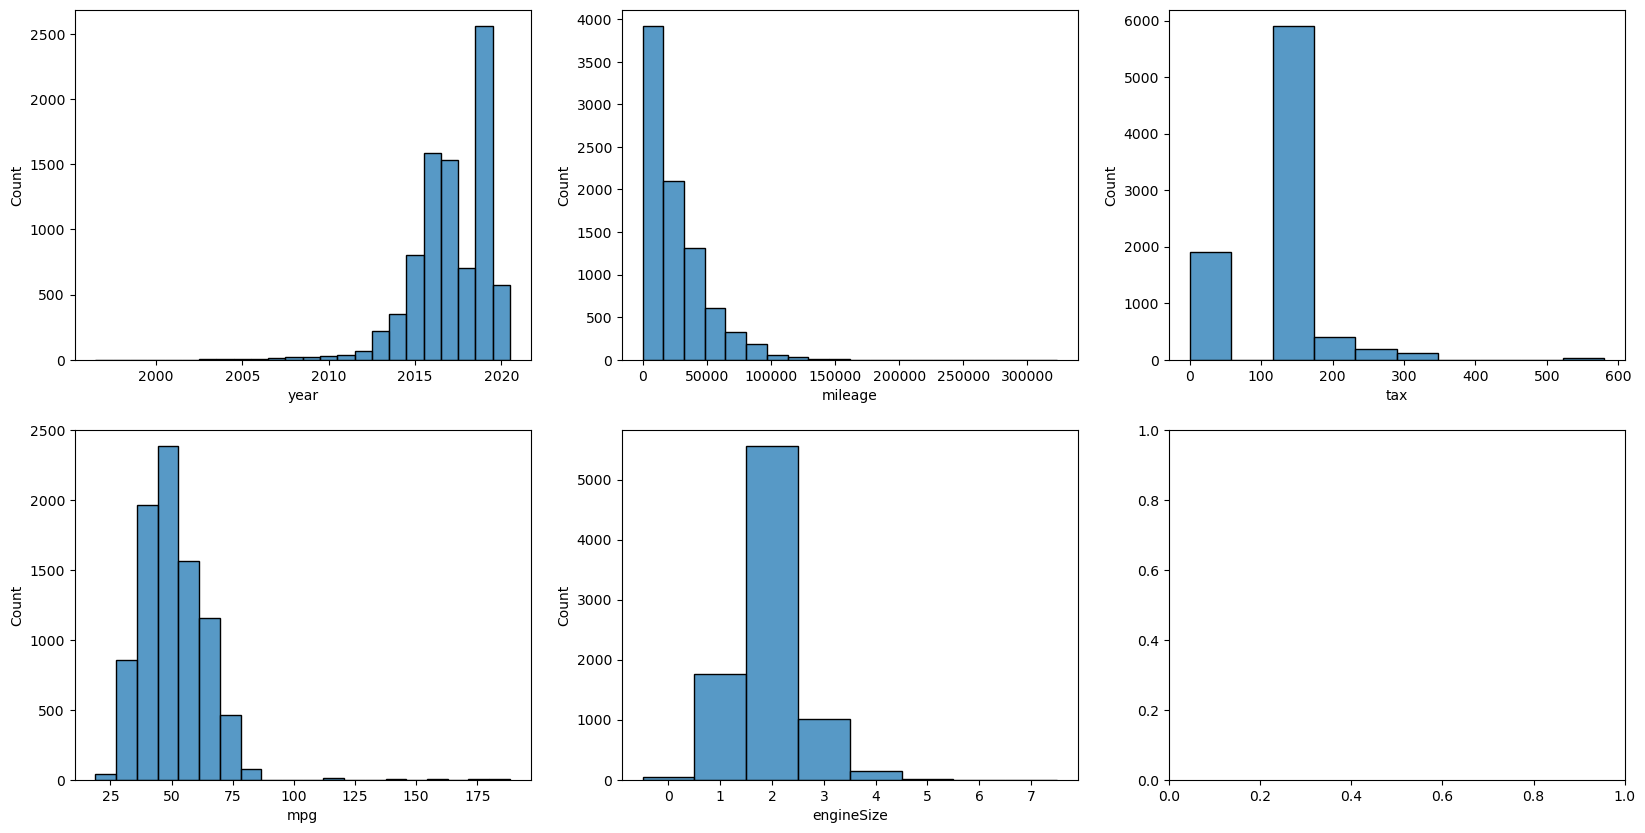

In [199]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(X_train['year'], discrete=True, ax=axs[0][0])
sns.histplot(X_train['mileage'], bins=20, ax=axs[0][1])
sns.histplot(X_train['tax'], bins=10, ax=axs[0][2])
sns.histplot(X_train['mpg'], bins=20, ax=axs[1][0])
sns.histplot(X_train['engineSize'], discrete=True, ax=axs[1][1])
plt.show()

Few values of engine size and tax turn out not to be as big of a problem as expected.

In [200]:
print('Number of distinct engine size values:', len(X_train['engineSize'].value_counts()))
print('Number of distinct tax values:', len(X_train['tax'].value_counts()))

Number of distinct engine size values: 19
Number of distinct tax values: 33


There are 33 distinct models, but 10 of them account for 95% of all observations.

In [201]:
X_train['model'].value_counts()[:10]

print(f'Top 10 models account for {X_train["model"].value_counts()[:10].sum() / len(X_train):.2f} of observations')

Top 10 models account for 0.95 of observations


While transmission is relatively balanced, in case of fuel type there is significant disproportion, there are hardly any Hybrids. This might cause some issues during cross-validation, there is a small possibility all of these will end up in one of the validation folds.

In [202]:
display(X_train['transmission'].value_counts())

display(X_train['fuelType'].value_counts())

Manual       3475
Semi-Auto    2877
Automatic    2182
Name: transmission, dtype: int64

Diesel    4424
Petrol    4088
Hybrid      22
Name: fuelType, dtype: int64

In the bottom row, we see, unsuprisingly, that:
- year (of production) is positively correlated with the price
- mileage is negatively correlated with the price
- engine size is positively correlated with the price

What is more surprising:
- mpg (fuel efficiency) is negatively correlated with the price, though this might be due to the fact that mpg is negatively correlated with engine size and milage, i.e. newer, stronger cars with lower mpg are more expensive

All of these display low to mdeium level of non-linearity around extreme values

Aside from that, we see that:
- mileage and production year are negatively correlated, as expected, so we'll need to be catious at feature selection stage

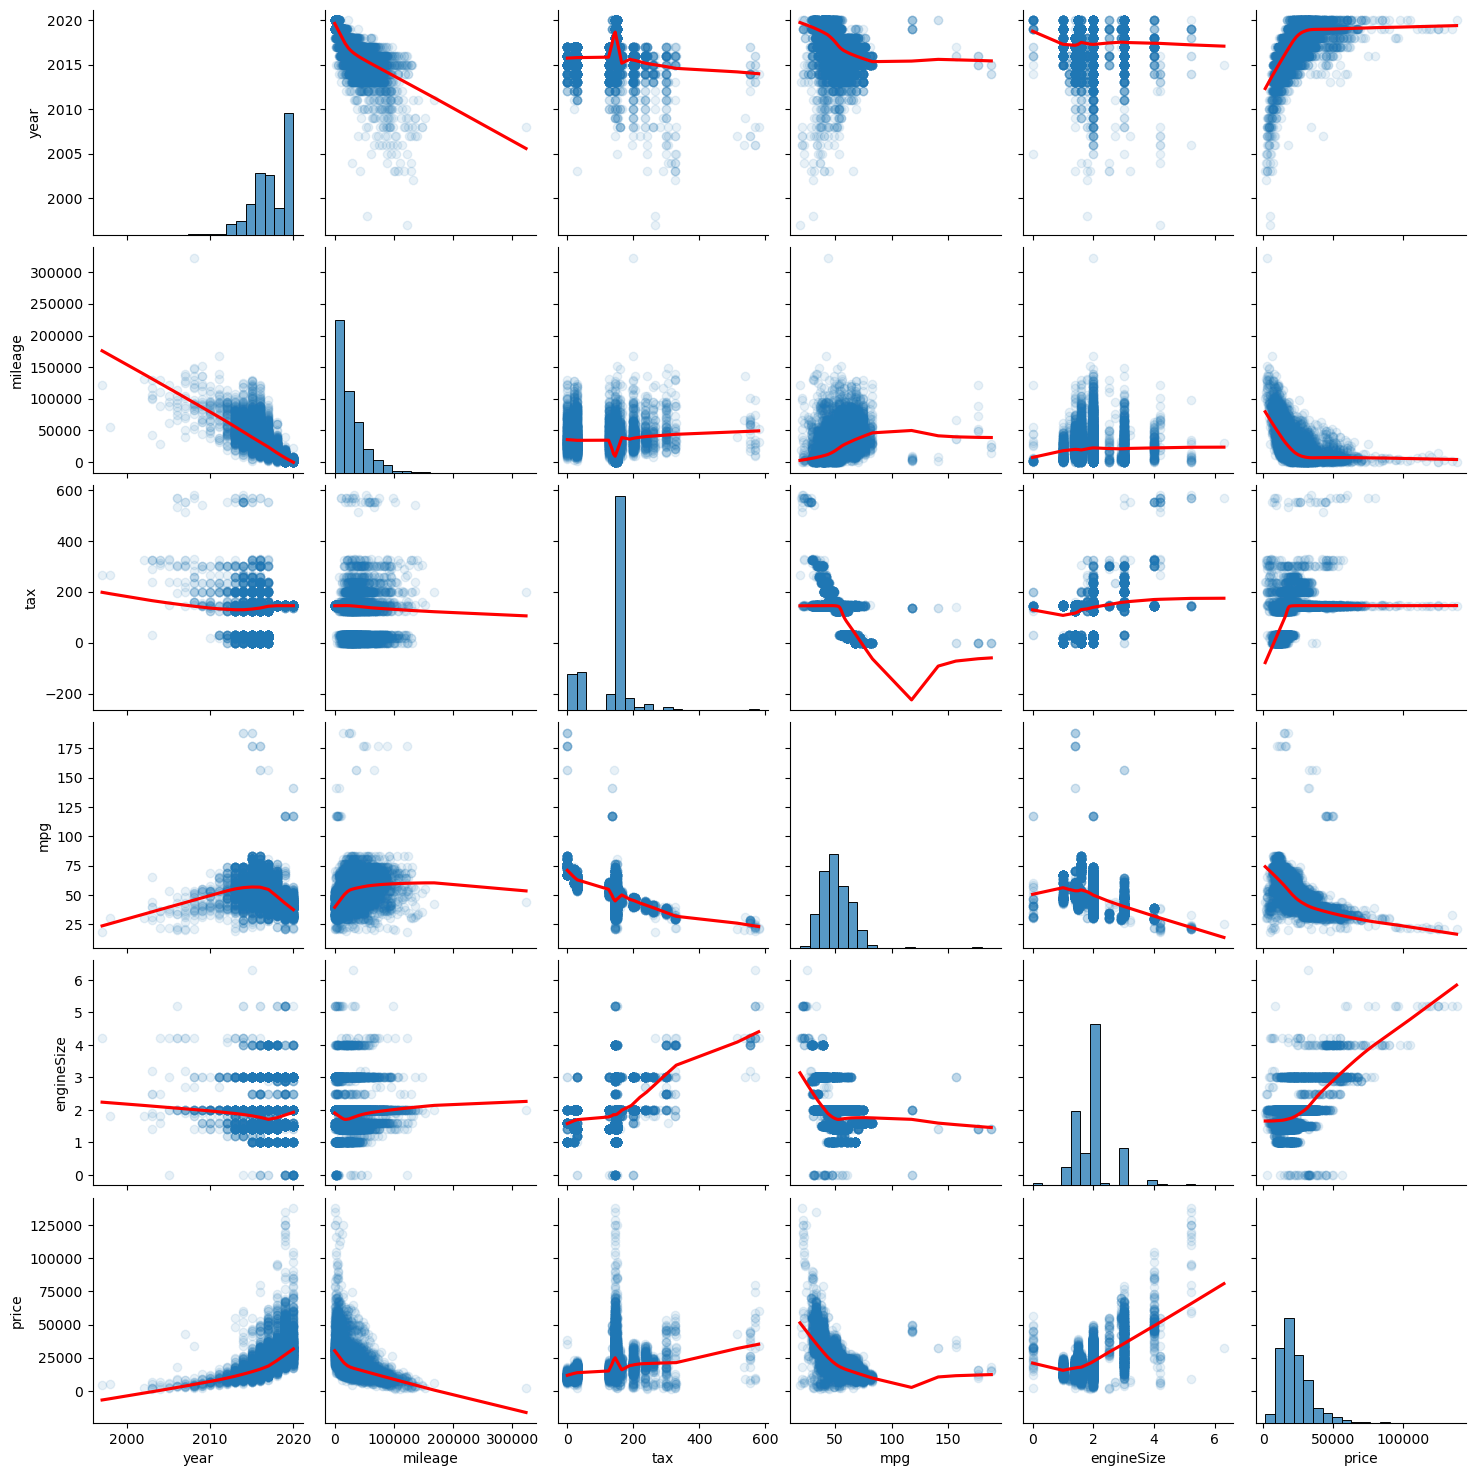

In [203]:
sns.pairplot(
    pd.concat([X_train, y_train], axis=1), kind='reg',
    plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}, 'ci': None, 'lowess': True},
    diag_kws={'bins': 20}
)
plt.show()

Categorical variables seem informative at first glance, e.g. automatic cars are positively associated with price, though there is not much difference between petrol and diesel cars in terms of price. Unsuprisingly the prices vary greatly across model types.

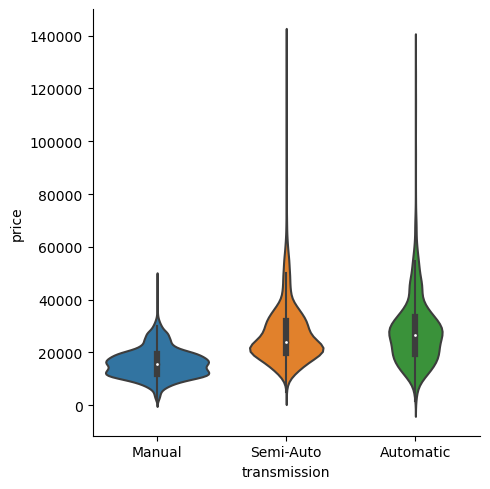

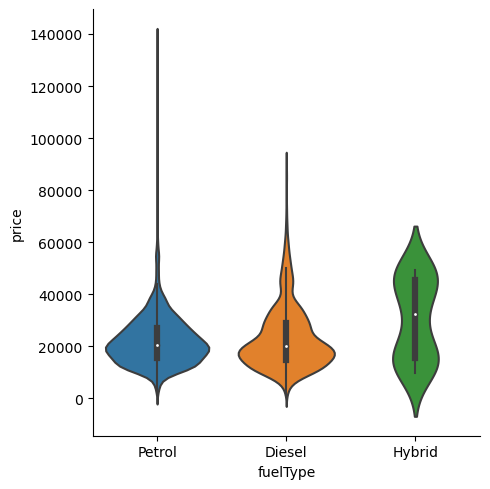

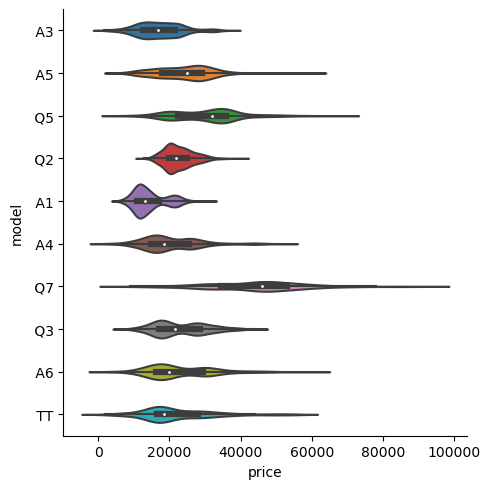

In [204]:
mask = X_train['model'].isin(X_train['model'].value_counts()[:10].index)

sns.catplot(data=pd.concat([X_train, y_train], axis=1), x='transmission', y='price', kind='violin')
sns.catplot(data=pd.concat([X_train, y_train], axis=1), x='fuelType', y='price', kind='violin')
sns.catplot(data=pd.concat([X_train, y_train], axis=1)[mask], x='price', y='model', kind='violin')
plt.show()

### Variable transformation


To stabilize variance and minimize skewness, we will apply Yeo-Johnson transform (since Box-Cox applies only to strictly positive data), the optimal scaling factor will be identified via maximum likelihood estimation.

To get a correct estimate of performance, we need to determine transformation parameters for each split separately, so at this point we only define the PowerTransformer, to be put later in the pipeline.

We will not transform variables for decision-tree based models, Random Forest and XGBoost, since they can model non-linearity naturally.

There are no missing values, so we don't need to impute.

In [205]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

We will one hot encode categorical variables.

We will group infrequent car models into 'other'. Theoretically this should be also done in a pipeline, so in this case the cross-validation score will be biased, but the impact, if any, is minimal. At the same time, this will make it easier to use native XGBoost API, which makes it much easier to use early-stopping with cross-validation.

We build the Top 10 list exclusively on the training data, so the test scores will not be impacted.

In [206]:
top10_models = X_train['model'].value_counts()[:10].index

In [207]:
X_train.loc[~X_train['model'].isin(top10_models), 'model'] = 'other'
X_test.loc[~X_test['model'].isin(top10_models), 'model'] = 'other'

for col in ['model', 'transmission', 'fuelType']:
    X_train[col] = X_train[col].astype('category')

for col in ['model', 'transmission', 'fuelType']:
    X_test[col] = X_test[col].astype('category')

#### Variable selection


Mileage and year have substantial correlation (-0.79), likewise mpg and tax, though only at moderate level (-0.63).

To address this, we will investigate whether regularization improves model performance by inducing sparsity.

In [208]:
corr = X_train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,year,mileage,tax,mpg,engineSize
year,1.00,-0.79,0.09,-0.35,-0.03
mileage,-0.79,1.00,-0.16,0.39,0.07
tax,0.09,-0.16,1.00,-0.63,0.40
mpg,-0.35,0.39,-0.63,1.00,-0.37
engineSize,-0.03,0.07,0.40,-0.37,1.00


#### Cross-validation

For hyperparameter tuning, we will use 5-fold cross validation.

First we train the baseline model (linear regression), we also try the regularized linear regression (Lasso), since some of the predictors were moderate-to-highly correlated. By just hand-picking a few values of alpha (15, 16, 17), we achieve best accuracy for this model - the overall benefit from regularization is minimal. 

In [209]:
lin_reg_transformer = make_column_transformer(
    (power_transformer, ['mileage', 'tax', 'mpg', 'engineSize']),
    (make_pipeline(StandardScaler(), power_transformer), ['year']),
    (OneHotEncoder(), ['model', 'transmission', 'fuelType']),
    remainder='passthrough'
)

lin_reg = make_pipeline(lin_reg_transformer, LinearRegression())
display(lin_reg)

lin_reg_cv_results = cross_validate(
    lin_reg, X_train, y_train, 
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5
)

display(pd.DataFrame(lin_reg_cv_results).agg('mean'))

lin_reg = make_pipeline(lin_reg_transformer, Lasso(alpha=16))

lin_reg_cv_results = cross_validate(
    lin_reg, X_train, y_train, 
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5
)

display(pd.DataFrame(lin_reg_cv_results).agg('mean'))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('powertransformer',
                                                  PowerTransformer(),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['model', 'transmission',
                                                   'fuelType'])])),
                ('linearregression', LinearRegression())])

fit_time                                      0.025693
score_time                                    0.002895
test_neg_root_mean_squared_error          -4806.851900
test_neg_mean_absolute_error              -2933.513138
test_neg_mean_absolute_percentage_error      -0.133870
dtype: float64

fit_time                                      0.024420
score_time                                    0.002793
test_neg_root_mean_squared_error          -4822.467858
test_neg_mean_absolute_error              -2926.593275
test_neg_mean_absolute_percentage_error      -0.132965
dtype: float64

Next, we train Random Forest. We use Bayesian Optimization to make hyperparameter tuning more efficient. This allows us to explore a wide range of hyperparameters in a reasonable time, since we are not trying all combinations, but rather those which are either expected to improve the score, or those which are very far in the hyperparameter space from combinations tried so far.

In [210]:
dtreg_transformer = make_column_transformer(
    (OneHotEncoder(), ['model', 'transmission', 'fuelType']),
    remainder='passthrough'
)

In [211]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=10, high=100, step=5),
        'max_depth': trial.suggest_int('max_depth', low=5, high=20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=10),
        'min_samples_split': trial.suggest_int('min_samples_split', low=1, high=10),
        'max_features': trial.suggest_float('max_features', low=0.7, high=1.0, step=0.05),
    }

    rf_reg = make_pipeline(dtreg_transformer, RandomForestRegressor(**params))

    rf_reg_cv_results = cross_validate(
        rf_reg, X_train, y_train,
        scoring='neg_mean_absolute_percentage_error',
        cv=5
    )

    score = rf_reg_cv_results['test_score'].mean()

    return score

study = optuna.create_study(sampler=TPESampler(seed=123), direction='maximize')
study.optimize(objective, n_trials=50)

cols = ['Iteration number', 'Score'] + list(study.best_params.keys())
results = [study.best_trial.number, study.best_trial.value] + list(study.best_params.values())
results_df = pd.DataFrame([results], columns = cols)
display(results_df)

,Iteration number,Score,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features
0,42,-0.073723,85,17,1,5,0.8


In [212]:
rf_params = {
    'n_estimators': 50,
    'max_depth': 16,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'max_features': 0.75,
}

rf_reg = make_pipeline(dtreg_transformer, RandomForestRegressor(**rf_params))
display(rf_reg)

rf_reg_cv_results = cross_validate(
    rf_reg, X_train, y_train,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    cv=5
)

pd.DataFrame(rf_reg_cv_results).agg('mean')

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['model', 'transmission',
                                                   'fuelType'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=16, max_features=0.75,
                                       min_samples_split=5, n_estimators=50))])

fit_time                                      0.397899
score_time                                    0.011815
test_neg_root_mean_squared_error          -2409.317122
test_neg_mean_absolute_error              -1542.992731
test_neg_mean_absolute_percentage_error      -0.073876
dtype: float64

Next, we train XGBoost. We first explore the hyperparameter space (again using Bayesian Optimization) at high learning rate (0.3) with low number of early stopping rounds. Then, after finding the best combination, we set the learning rate to a low value (0.1) and find the number of boosting rounds where the score stops improving. Then we train the final model, using the best combination of hyperparameters and the number of boosting rounds we found in the last step.

In [213]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)

In [214]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    params = {
        'objective': 'reg:squarederror',
        'eta': 0.3,
        'max_depth': trial.suggest_int('max_depth', low=4, high=10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', low=0.6, high=1, step=0.1),
        'subsample': trial.suggest_float('subsample', low=0.6, high=1, step=0.1),
        'alpha': trial.suggest_float('alpha', low=0, high=0.3, step=0.05),
        'eval_metric': 'mape',
    }

    result = xgb.cv(params, dtrain, num_boost_round=50, early_stopping_rounds=5, nfold=5, seed=123)
    score = result['test-mape-mean'].iloc[-1]
    score

    return score

study = optuna.create_study(sampler=TPESampler(seed=123), direction='minimize')
study.optimize(objective, n_trials=50)

cols = ['Iteration number', 'Score'] + list(study.best_params.keys())
results = [study.best_trial.number, study.best_trial.value] + list(study.best_params.values())
results_df = pd.DataFrame([results], columns = cols)
display(results_df)

,Iteration number,Score,max_depth,colsample_bytree,subsample,alpha
0,49,0.07277,10,0.7,1.0,0.15


In [215]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 10,
    'colsample_bytree': 0.7,
    'subsample': 1.0,
    'alpha': 0.15,
    'eval_metric': 'mape',
}

results = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=10, nfold=5, seed=123)

print('Boosting rounds:', len(results))
print('Best MAPE:', results['test-mape-mean'].iloc[-1])

Boosting rounds: 170
Best MAPE: 0.0695687413510004


In [216]:
xgb_params['eval_metric'] = ['mape', 'rmse', 'mae']
results = xgb.cv(xgb_params, dtrain, num_boost_round=170, nfold=5, seed=123)
print('MAPE:', results['test-mape-mean'].iloc[-1])
print('MAE:', results['test-mae-mean'].iloc[-1])
print('RMSE:', results['test-rmse-mean'].iloc[-1])

MAPE: 0.0695687413510004
MAE: 1470.5721575737123
RMSE: 2273.0965697507677


#### Model assessment and comparison

In [217]:
def print_performance_summary(y_true, y_pred):
    print(f'MAPE: {metrics.mean_absolute_percentage_error(y_true, y_pred):.4f}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred):.2f}')
    print(f'RMSE: {metrics.mean_squared_error(y_true, y_pred)**0.5:.2f}')

In [218]:
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)

print_performance_summary(y_test, lin_pred)

MAPE: 0.1335
MAE: 2982.96
RMSE: 5141.44


In [219]:
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

print_performance_summary(y_test, rf_pred)

MAPE: 0.0673
MAE: 1464.24
RMSE: 2214.58


In [220]:
xgb_reg = xgb.train(xgb_params, dtrain, num_boost_round=201)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
xgb_pred = xgb_reg.predict(dtest)

print_performance_summary(y_test, xgb_pred)

MAPE: 0.0649
MAE: 1437.34
RMSE: 2201.76


The test set performance is better than training set, how to explain this? The hypothesis is:
- we did 5-fold cross validation, so model trained on each split used only 80% of the (training) data. The final model used 100% of the training data, i.e. 25% more.
- the ML models are expected to perform better, the more observations we have. Some models benefit more from this than others.

We can explore this effect using the learning curves for Random Forest and linear regression, this time on full dataset. The X-axis represents increasing number of observations included in the training set (so we train the model on increasingly larger datasets). We see that RF benefits a lot from increase in dataset size, while linear regression performance does not.

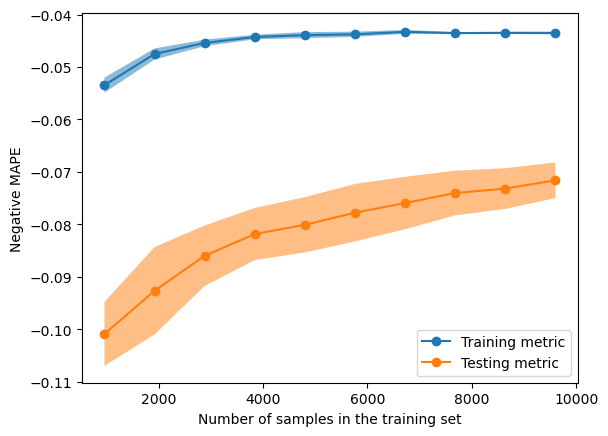

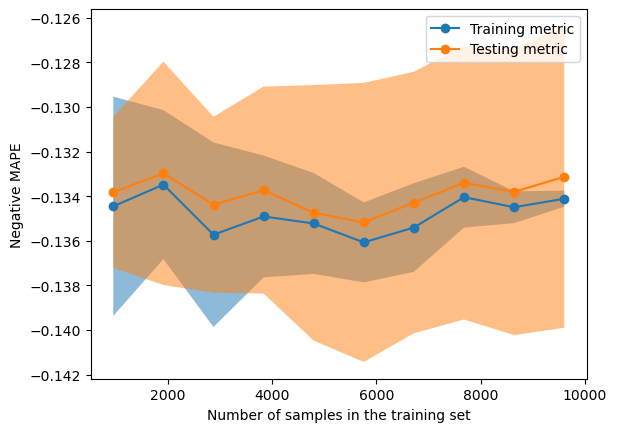

In [221]:
import numpy as np

common_params = {
    "X": pd.concat([X_train, X_test], axis=0),
    "y": pd.concat([y_train, y_test], axis=0),
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.1, random_state=123),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Negative MAPE",
    "scoring": metrics.make_scorer(metrics.mean_absolute_percentage_error, greater_is_better=False),
}

LearningCurveDisplay.from_estimator(rf_reg, **common_params,)
LearningCurveDisplay.from_estimator(lin_reg, **common_params,)

Finally, we attempt to train a Neural network with two hidden layers, with gradient clipping at norm 1 and without dropout.

In [222]:
import torch
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, dimensions, cfg_network):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dimensions = dimensions
        layers = []
        prev_n = dimensions[0]
        for cfg_layer in cfg_network.values():
            layers.append(nn.Linear(prev_n, cfg_layer['neurons']))
            if cfg_layer['dropout'][0]:
                layers.append(nn.Dropout(cfg_layer['dropout'][1], inplace=True))
            layers.append(cfg_layer['activation'])
            prev_n = cfg_layer['neurons']

        layers.append(nn.Linear(prev_n, dimensions[1]))
        # layers.append(nn.Softmax(dim=1))
        self.linear_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

cfg_network={
    1: {"neurons":4, "activation": nn.ReLU(), "dropout": [False, None]},
    2: {"neurons":4, "activation": nn.ReLU(), "dropout": [False, None]},
}

torch.manual_seed(123)
model = NeuralNetwork([5, 1], cfg_network=cfg_network)
display(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [223]:
model = NeuralNetwork([5, 1], cfg_network=cfg_network)

nn_df = pd.concat([X_train[['mileage', 'tax', 'mpg', 'engineSize', 'year']], y_train], axis=1)
df_train, df_validate = train_test_split(nn_df, train_size=0.8, random_state=123)

X_nn_train = torch.tensor(df_train.iloc[:, :-1].values, device='cpu', requires_grad=True).to(torch.float32)
y_nn_train = torch.tensor(df_train.iloc[:, -1].values, device='cpu').to(torch.float32)

X_nn_validate = torch.tensor(df_validate.iloc[:, :-1].values, device='cpu', requires_grad=False).to(torch.float32)
y_nn_validate = torch.tensor(df_validate.iloc[:, -1].values, device='cpu').to(torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, eps=1e-8)

loss_curve_train = []
loss_curve_validate = []

for epoch in range(10000):
    optimizer.zero_grad()

    probs_train = model.forward(X_nn_train)
    loss_train = nn.MSELoss().forward(probs_train[:, 0], y_nn_train)
    loss_curve_train.append(loss_train.detach().numpy())

    probs_validate = model.forward(X_nn_validate)
    loss_validate = nn.MSELoss().forward(probs_validate[:, 0], y_nn_validate)
    loss_curve_validate.append(loss_validate.detach().numpy())

    loss_train.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

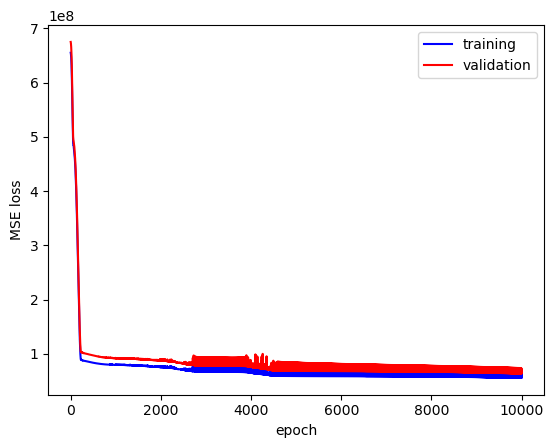

In [224]:
fig, ax = plt.subplots()

ax.plot(loss_curve_train, color='blue', label='training')
ax.plot(loss_curve_validate, color='red', label='validation')
ax.legend()

ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')

plt.show()

The model however did quite poorly - to achieve better results, we'd need to experiment with architecture and apply transformations on predictors.

In [225]:
model.eval()
y_pred = model.forward(X_nn_validate)
print('MAPE:', metrics.mean_absolute_percentage_error(y_nn_validate, y_pred.detach().numpy()))

MAPE: 0.34892884


#### Summary

In summary, XGBoost performed the best, delivering just 6.5% MAPE (although the difference between Random Forest is not that high). Linear regression turned out to be highly inaccurate, likely due to the nonlinear relationships between predictors and the target variables. Neural network performed poorly, which isn't suprising given we are working with tabular data, however we have not optimized the architecture and did not apply all transformations to predictors.


Finally, let's explore which features were the often used in the XGBoost regressor. It seems the mileage, fuel efficiency, year of production and model were used most often for splitting the trees, although the differences between predictors are not high. Unsuprisingly, the fuelType was used least often, as we saw that on average there was very little difference in price between cars running on different fuel types (except for 22 hybrid we saw in the training set).

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

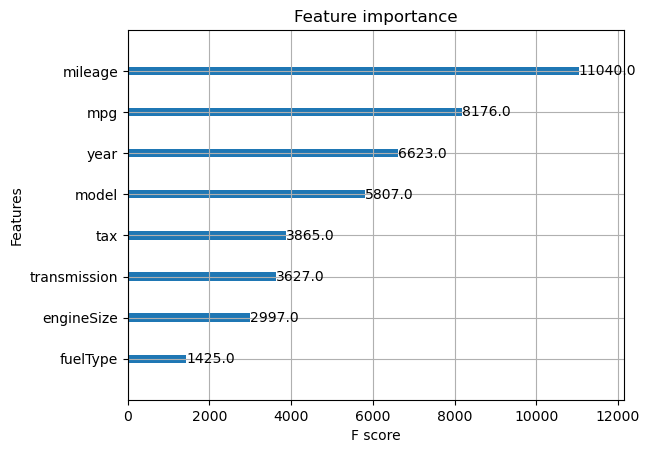

In [226]:
xgb.plot_importance(xgb_reg)